In [175]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
df=pd.read_csv('./parsed data/table.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59841 entries, 0 to 59840
Data columns (total 10 columns):
payload_smog_index                      59841 non-null float64
kl_divergence_eng_lang_e                59841 non-null float64
is_spam                                 59841 non-null bool
organization                            59841 non-null bool
multipart_count                         59841 non-null int64
kl_divergence_eng_lang                  59841 non-null float64
payload_dale_chall_readability_score    59841 non-null float64
payload_coleman_liau_index              59841 non-null float64
frm_fuzz_set_ratio                      59841 non-null float64
cc                                      59841 non-null bool
dtypes: bool(3), float64(6), int64(1)
memory usage: 3.4 MB


In [176]:
if 'is_spam' in df:
    y = df['is_spam'].values # get the labels we want
    del df['is_spam'] # get rid of the class label
    X=df.values

In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

lr_sk = LogisticRegression() # all params default

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Precision of: ',precision_score(y,yhat))
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 754 ms, sys: 14 ms, total: 768 ms
Wall time: 772 ms
[[  8.92710200e-02  -2.28644044e+00  -4.59046617e+00   2.02802897e-01
   -3.29863628e+00   2.55039341e-02  -2.26406911e-05  -6.27585797e-03
   -4.60134192e+00]]
Precision of:  0.996419203064
Accuracy of:  0.993282197824


In [178]:
#Training/testing 
from sklearn.cross_validation import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = .8)
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=10, class_weight=None)
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    conf=mt.confusion_matrix(y[test_indices],y_hat)
    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",conf)
    print("false positive", conf[0][1]/np.sum(conf)) 
    print("false negative", conf[1][0]/np.sum(conf))

====Iteration 0  ====
accuracy 0.99463162952
confusion matrix
 [[28475    34]
 [  223 19141]]
false positive 0.000710212437073
false negative 0.00465815804316
====Iteration 1  ====
accuracy 0.994151191695
confusion matrix
 [[28441    58]
 [  222 19152]]
false positive 0.00121153886324
false negative 0.00463726944207
====Iteration 2  ====
accuracy 0.982871347106
confusion matrix
 [[28374   144]
 [  676 18679]]
false positive 0.00300795855702
false negative 0.0141206943371


In [179]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
import plotly

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([ ("SCL", std_scl),
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [180]:
import plotly
plotly.offline.init_notebook_mode()
error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

In [229]:
lr_sk = LogisticRegression(solver='lbfgs',n_jobs=-1) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',precision_score(y,yhat))
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 96.2 ms, sys: 31.8 ms, total: 128 ms
Wall time: 1.02 s
[[  1.79675097e-01  -2.13069977e-01  -3.75407024e+00  -6.64550850e-01
   -3.07394999e-01   6.08521185e-02   4.04493544e-05   4.23050784e-02
   -5.76484178e+00]]
Accuracy of:  0.964522026815
Accuracy of:  0.951454688257


In [230]:
lr_sk = LogisticRegression(solver='liblinear',n_jobs=4) 

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',precision_score(y,yhat))
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 682 ms, sys: 8.41 ms, total: 690 ms
Wall time: 691 ms
[[  8.92710200e-02  -2.28644044e+00  -4.59046617e+00   2.02802897e-01
   -3.29863628e+00   2.55039341e-02  -2.26406911e-05  -6.27585797e-03
   -4.60134192e+00]]
Accuracy of:  0.996419203064
Accuracy of:  0.993282197824


In [231]:
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='newton-cg',n_jobs=4) 

%time lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',precision_score(y,yhat))
print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 98 ms, sys: 33.9 ms, total: 132 ms
Wall time: 4.45 s
[[  2.65801548e-02  -7.37238820e+00  -5.42458462e+00   8.56992778e-02
   -1.06361079e+01  -8.11107744e-03  -1.80698782e-04  -4.07854725e-02
   -8.44364505e+00]]
Accuracy of:  0.999253483743
Accuracy of:  0.997142427433


In [ ]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
piped_object = Pipeline([("SCL",std_scl ),
                         ('logit_model', clf)]) # and then do this
weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].feature_importances_)
    
weights = np.array(weights)

In [185]:
import plotly
plotly.offline.init_notebook_mode()
error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Decision tree Weights, with error bars'}

plotly.offline.iplot(fig)

(0.94096116123970186, 1.0)

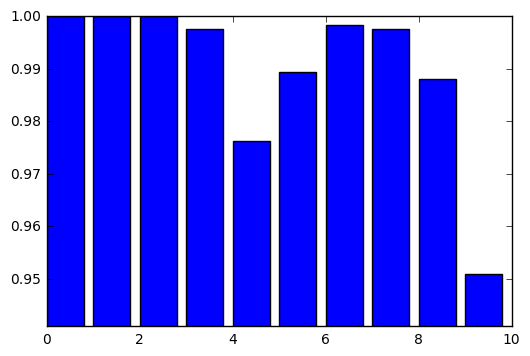

In [232]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,  StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
cv = StratifiedKFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(precision_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

(0.97979591836734692, 1.0)

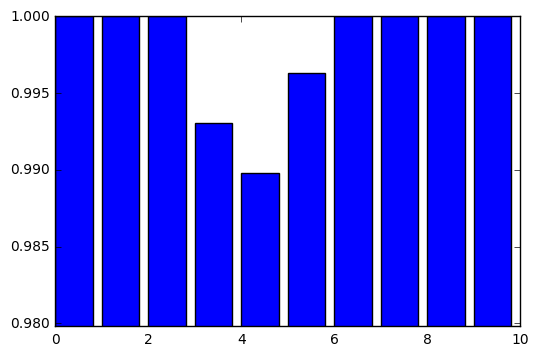

In [233]:
clf =LogisticRegression(solver='newton-cg')

#select cross validation
cv = StratifiedKFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(precision_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

In [236]:
#split  data for parameter hypertuning
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [237]:
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', LogisticRegression(solver='newton-cg',class_weight='balanced', random_state=1))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Precision=", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precision= 0.994949494949
             precision    recall  f1-score   support

      False       0.99      1.00      0.99      7181
       True       0.99      0.99      0.99      4788

avg / total       0.99      0.99      0.99     11969



In [238]:
from sklearn.learning_curve import validation_curve
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()


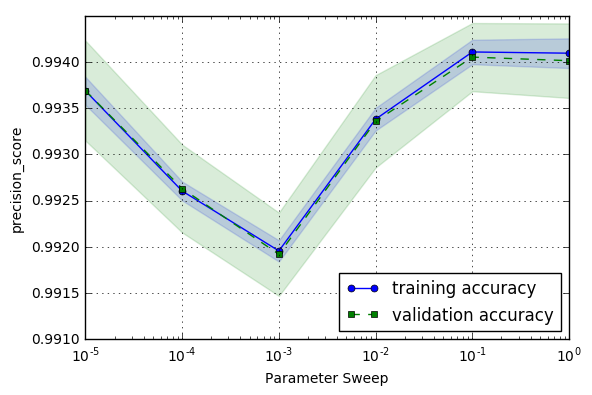

In [239]:
scorer = make_scorer(precision_score, average='macro')
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__C', 
                param_range=param_range,
                cv=5,n_jobs=-1)
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.ylabel('precision_score')
plt.show()

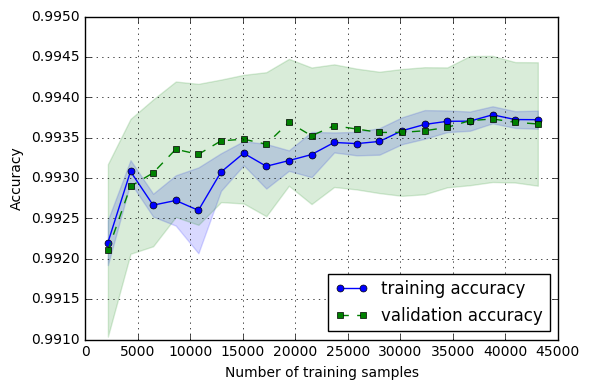

In [240]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.05, 1.0, 20),
                                                       cv=10,
                                                       n_jobs=-1)
plt.figure()
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

In [241]:
#Using 20% data to train and C as 1 in the logistic model, we get a slightly higher precision score. The best part about
#this is that we're using way less data to train and still getting similar scores.
XLR_train, XLR_test, yLR_train, yLR_test = train_test_split(X, y, test_size=0.80, random_state=1)
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', LogisticRegression(C=.1,solver='newton-cg',class_weight='balanced', random_state=1))])
pipe_lr.fit(XLR_train, yLR_train)
yhat=pipe_lr.predict(XLR_test)
print("Precision=", precision_score(yLR_test, yhat))
print(classification_report(yLR_test, yhat))

Precision= 0.998016183764
             precision    recall  f1-score   support

      False       0.99      1.00      0.99     28467
       True       1.00      0.99      0.99     19406

avg / total       0.99      0.99      0.99     47873



In [272]:
from sklearn.svm import SVC
from sklearn import preprocessing
pipe_SVM=Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', (SVC(kernel='poly')))])
pipe_SVM.fit(X_train, y_train)
y_pred = pipe_SVM.predict(X_test)
print("Precision=", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precision= 0.997445177773
             precision    recall  f1-score   support

      False       0.99      1.00      0.99      7181
       True       1.00      0.98      0.99      4788

avg / total       0.99      0.99      0.99     11969



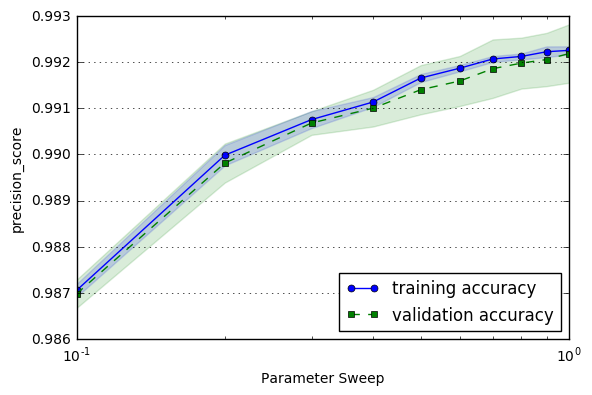

In [273]:
scorer = make_scorer(precision_score, average='macro')
param_range = [.1, .2,.3,.4,.5,.6,.7, .8, .9, 1]

train_scores, test_scores = validation_curve(
                estimator=pipe_SVM, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__gamma', 
                param_range=param_range,
                cv=5,n_jobs=-1)
plot_filled(train_scores, test_scores, param_range, xlabel='gamma')
plt.ylabel('precision_score')
plt.show()

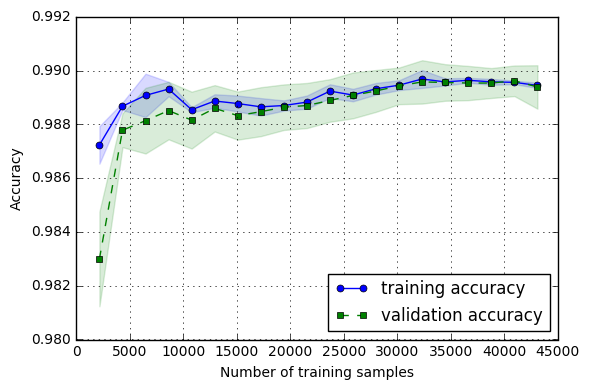

In [275]:
train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_SVM,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.05, 1.0, 20),
                                                       cv=10,
                                                       n_jobs=-1)
plt.figure()
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

In [280]:
XSVM_train, XSVM_test, ySVM_train, ySVM_test = train_test_split(X, y, test_size=0.80, random_state=1)
pipe_SVM = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf',SVC(kernel='poly', gamma=1))])
pipe_SVM.fit(XSVM_train, ySVM_train)
yhat=pipe_SVM.predict(XSVM_test)
print("Precision=", precision_score(ySVM_test, yhat))
print(classification_report(ySVM_test, yhat))

Precision= 0.999051483375
             precision    recall  f1-score   support

      False       0.98      1.00      0.99     28467
       True       1.00      0.98      0.99     19406

avg / total       0.99      0.99      0.99     47873



In [269]:
pipe_DT= Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', (DecisionTreeClassifier(random_state=0)))])
pipe_DT.fit(X_train, y_train)
y_pred = pipe_DT.predict(X_test)
print("Precision=", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precision= 0.994775339603
             precision    recall  f1-score   support

      False       1.00      1.00      1.00      7181
       True       0.99      0.99      0.99      4788

avg / total       1.00      1.00      1.00     11969



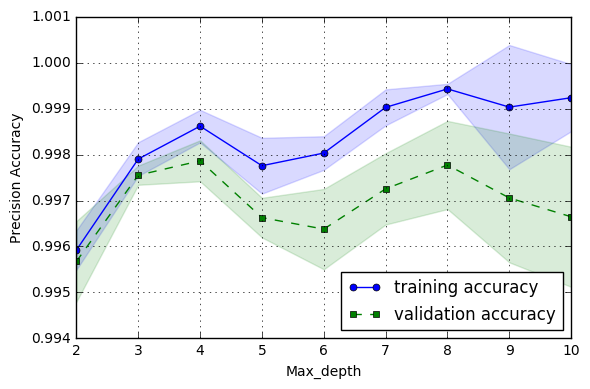

In [243]:
scorer = make_scorer(precision_score)
param_range = [2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(
                estimator=pipe_DT, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__max_depth', 
                param_range=param_range,
                cv=5,n_jobs=-1)

plot_filled(train_scores, test_scores, param_range, xlabel='Max_depth')
plt.ylabel('Precision Accuracy')
plt.show()

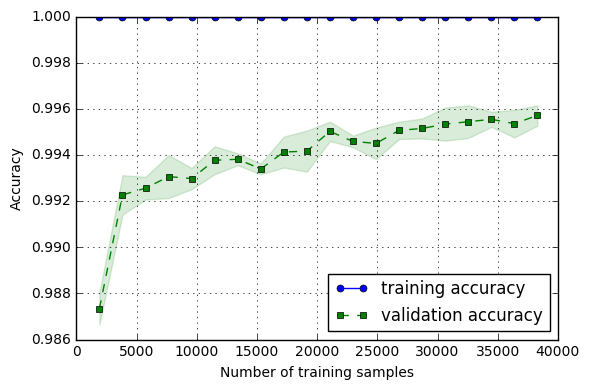

In [270]:
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_DT,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.05, 1.0, 20),
                                                       cv=5,
                                                       n_jobs=-1)
plt.figure()
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

In [246]:
XDT_train, XDT_test, yDT_train, yDT_test = train_test_split(X, y, test_size=0.80, random_state=1)
pipe_DT = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', DecisionTreeClassifier(random_state=0, max_depth=4))])
pipe_DT.fit(XDT_train, yDT_train)
yhat=pipe_DT.predict(XDT_test)
print("Precision=", precision_score(yDT_test, yhat))
print("accuracy=", accuracy_score(yDT_test, yhat))

Precision= 0.99744472257
accuracy= 0.993148538842


In [258]:
from sklearn.neural_network import MLPClassifier
pipe_MLP = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', (MLPClassifier(activation="logistic"))
)])
pipe_MLP.fit(X_train, y_train)
y_pred = pipe_MLP.predict(X_test)
print("Precision=", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precision= 0.995787700084
             precision    recall  f1-score   support

      False       0.99      1.00      0.99      7181
       True       1.00      0.99      0.99      4788

avg / total       0.99      0.99      0.99     11969



In [259]:
train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_MLP,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=-1)


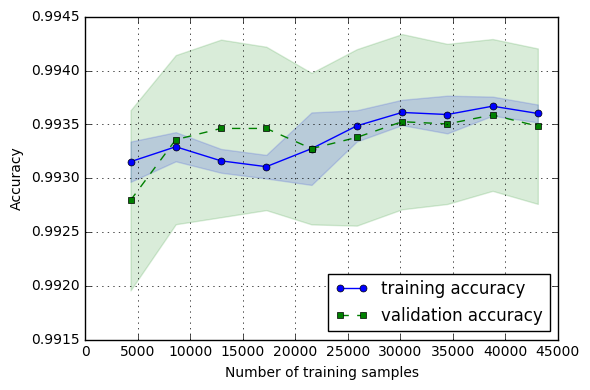

In [260]:
plt.figure()
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

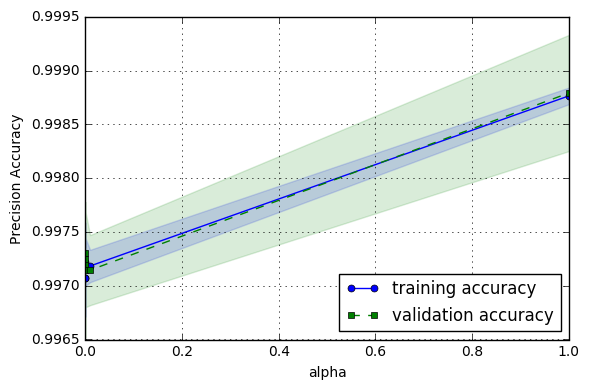

In [261]:
param_range = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1]

train_scores, test_scores = validation_curve(
                estimator=pipe_MLP, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__alpha', 
                param_range=param_range,
                cv=5,n_jobs=-1)

plot_filled(train_scores, test_scores, param_range, xlabel='alpha')
plt.ylabel('Precision Accuracy')
plt.show()

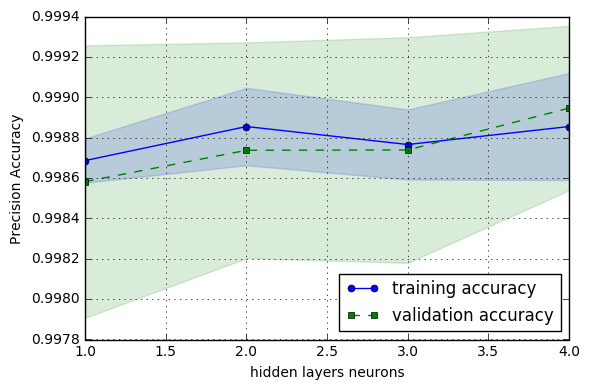

In [262]:
pipe_MLP = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', MLPClassifier(activation="logistic", alpha=1))])
param_range = [(50,50),(50,100),(100,50),(100,100)]

train_scores, test_scores = validation_curve(
                estimator=pipe_MLP, 
                X=X_train, 
                y=y_train, 
                scoring = scorer,
                param_name='clf__hidden_layer_sizes', 
                param_range=param_range,
                cv=5,n_jobs=-1)

plot_filled(train_scores, test_scores, [1, 2, 3, 4], xlabel='hidden layers neurons')
plt.ylabel('Precision Accuracy')
plt.show()

In [263]:
XMLP_train, XMLP_test, yMLP_train, yMLP_test = train_test_split(X, y, test_size=0.80, random_state=1)
pipe_MLP = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', MLPClassifier(activation="logistic", alpha=1, hidden_layer_sizes=(100,100)))])
pipe_MLP.fit(XMLP_train, yMLP_train)
yhat=pipe_MLP.predict(XMLP_test)
print("Precision=", precision_score(yMLP_test, yhat))
print(classification_report(yMLP_test, yhat))

Precision= 0.999099480877
             precision    recall  f1-score   support

      False       0.98      1.00      0.99     28467
       True       1.00      0.97      0.99     19406

avg / total       0.99      0.99      0.99     47873



In [285]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
XENS_train, XENS_test, yENS_train, yENS_test = train_test_split(X, y, test_size=0.80, random_state=1)
pipe_MLP = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', MLPClassifier(activation="logistic", alpha=1, hidden_layer_sizes=(100,100)))])
pipe_DT = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', DecisionTreeClassifier(random_state=0, max_depth=4))])
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf', LogisticRegression(solver='newton-cg', C=.1,class_weight='balanced', random_state=1))])
pipe_SVM = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=3,random_state=1)),
                    ('clf',SVC(kernel='poly', gamma=1,probability=True))])
eclf1 = VotingClassifier(estimators=[ ('MLP', pipe_MLP),
                                     ('DT', pipe_DT),
                                     ('lr', pipe_lr),
                                     ('SVM', pipe_SVM)], 
                         voting='soft')
eclf1.fit(XENS_train, yENS_train)
yhat=eclf1.predict(XENS_test)
print("Precision=", precision_score(yENS_test, yhat))
print(classification_report(yMLP_test, yhat))


Precision= 0.99874411303
             precision    recall  f1-score   support

      False       0.99      1.00      0.99     28467
       True       1.00      0.98      0.99     19406

avg / total       0.99      0.99      0.99     47873

